In [ ]:
# default_exp data.transforms

In [ ]:
# hide 
import sys
sys.path.append('..')
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *

# from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

In [ ]:
# hide
from nbdev.showdoc import *
from fastseq.core import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [ ]:
# export
class NormalizeTS(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self,):
        self.m, self.s = 0, 0
        
    def encodes(self, o):         
        self.m, self.s = torch.mean(o[0],-1,keepdim=True), o[0].std(-1,keepdim=True)+1e-7         
        return Tuple([(o[i]-self.m)/self.s for i in range(len(o))])
    
    def decodes(self, o): 
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
                        
        return Tuple([(o[i]*self.s)+self.m for i in range(len(o))])
        
        
        

[False, False] False
[False, False] False


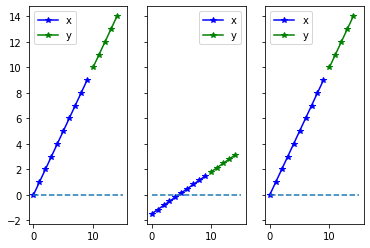

In [ ]:
norm = NormalizeTS()
o = (TSTensorSeq(torch.arange(10.)),TSTensorSeqy( torch.arange(10.,15),x_len=10))
o_en = norm(o)
test_eq(o_en[0].mean(), 0)
test_eq(o_en[1].mean()==0, False)
dec_o = norm.decode(o_en)
test_eq(dec_o[0],o[0])

f,axs = plt.subplots(1,3, sharey=True)
ax = o[0].show(axs[0])
o[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = o_en[0].show(axs[1])
o_en[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = dec_o[0].show(axs[2])
dec_o[1].show(ax)
ax.plot([0,15],[0,0],'--')


[False, False] False
[False, False] False
[False, False] False
[False, False] False


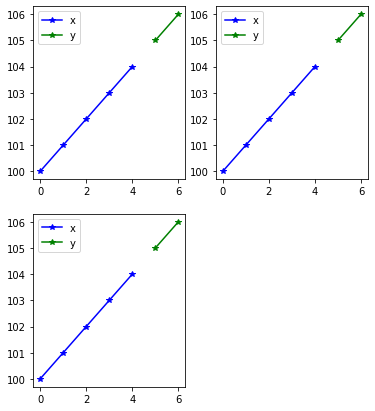

In [ ]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
ints = L( np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), num_workers = 1)
for o in dl:
    test_close(o[0].mean(),0)
    test_close(o[0].std(-1),1)
    test_eq(type(o),Tuple)
    
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    test_eq(type(o_new),Tuple)
    
test_eq(type(dl.one_batch()),Tuple)

dl.show_batch()

[True, True] True
[True, True] True
[False, False] True
[False, False] False
[True, True] True
[True, True] True


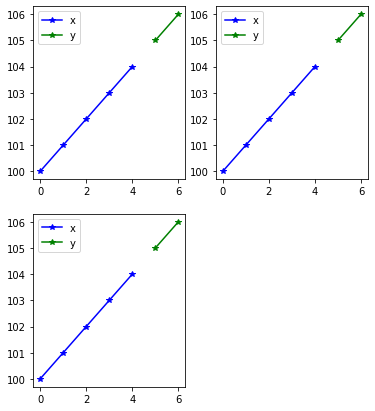

In [ ]:
# hide
if torch.cuda.is_available():
    from fastseq.data.load import *
    horizon,lookback = 2,5
    ints = L(tensor(o) for o in  [ np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,])

    dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), num_workers = 1, device=torch.device('cuda'))    
    for o in dl:
#         test if data on cuda will will stay there
        test_eq(o[0].is_cuda, True)
        dec_o = dl.after_batch[0].decode(o)
        test_eq(dec_o[0].is_cuda, True)  
        
#         test if o is already moved to cpu
        dec_o = dl.after_batch[0].decode(to_cpu(o))
        test_eq(dec_o[0].is_cuda, False)  
        
        
    dl.show_batch()

In [ ]:
# hide
# test if o is cuda but m,s are on cpu
if torch.cuda.is_available():
    norm = NormalizeTS()
    o = (TSTensorSeq(torch.arange(10.)),TSTensorSeqy( torch.arange(10.,15),x_len=10))
    o_en = norm(o)
    test_eq(o_en[0].mean(), 0)
    test_eq(o_en[1].mean()==0, False)
    dec_o = norm.decode(to_device(o_en))
    test_eq(dec_o[0],to_device(o[0]))

    # test if o_enc[0] and o_enc[1] are on different devices
    o_enc = Tuple([to_device(o_en[0],'cpu'),to_device(o_en[1],'cuda'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],o[0])

    o_enc = Tuple([to_device(o_en[0],'cuda'),to_device(o_en[1],'cpu'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],to_device(o[0]))
    
    norm.m, norm.s = to_device(norm.m), to_device(norm.s)
    o_enc = Tuple([to_device(o_en[0],'cuda'),to_device(o_en[1],'cpu'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],to_device(o[0]))

[True, True] False
[True, True] True
[False, True] True
[False, False] False
[True, False] False
[True, True] True
[True, False] True
[True, True] True


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 07_interpret.ipynb.
Converted 10_metrics.ipynb.
Converted 11_nbeats.metrics.ipynb.
Converted index.ipynb.
